2.2.0

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)
<CacheDataset shapes: ((28,), ()), types: (tf.float32, tf.float32)>
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 16)                464       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________
None

Epoch: 0, accuracy:0.4697,  binary_crossentropy:0.9663, 

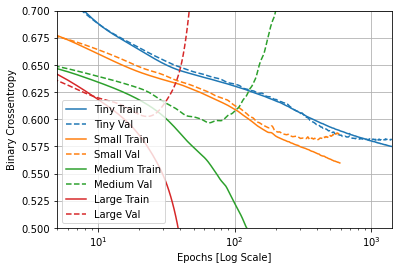

In [3]:

import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

from IPython import display
from matplotlib import pyplot as plt

import numpy as np

import pathlib
import shutil
import tempfile

print(tf.__version__)
print()

logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

# Higgs dataset - contains 11 000 000 examples
# each example has 28 features and binary class label
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')
FEATURES = 28

# used to read csv records directly from gzip file with no intermediate decompression step
# returns a list of scalars for each record
ds = tf.data.experimental.CsvDataset(gz, [float(),]*(FEATURES+1), compression_type="GZIP")

# repacks list of scalars into a (feature_vector, label) pair
def pack_row(*row):
    label = row[0]
    features = tf.stack(row[1:], 1)
    return features, label

# make a new dataset that repacks rows via batches
# 1 batch = 10 000 examples
# apply pack_row function to each batch, split batches back into individual records
packed_ds = ds.batch(10000).map(pack_row).unbatch()

# have a look at one of the feature, label sets
for features, label in packed_ds.batch(1000).take(1):
    print(features[0])
    plt.hist(features.numpy().flatten(), bins = 101)
    # plt.show()
    plt.close()

# first 1000 samples for validation, next 10,000 for training
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN // BATCH_SIZE
# ^ double slash rounds to the nearest whole number (floor division) I think it truncates

# Dataset cche ensures loader doesn't need to re-read data from file on each epoch
validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

# These datsets return individual examples
# batch method: create batches of appropriate size for training
print(train_ds)


# before batching, remember to shuffle and repeat training set (is this done)
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)


# simple approach - prevent overfitting, minimise number of learnable parameters
# learnable parameters - a model's "capacity"
# model with greater parameters, more 'memorization capacity'
#       learn dictionary-like mapping between training and targets, little generalisation power
# limited memorization resources - minimise loss by learning compressed representations which have more predictive power
#       if mdoel too small, difficulty fitting to training data
#       balance between too much capacity, too little capacity
#       best approach to determine capcity - experiment with series of different architectures

# start with few layers and parameters
# increase size of layers, add noew layers until diminishing returns on validation loss

# TRAINING procedure
# many models train better if you gradually reduce the learning rate during training
#       use optimizers.shcedules to reduce the learning rate over time

# defined schedule which hyperbolically decreases learning rate to 1/2 of the base rate at 1000 epoch, 1/3 of base rate at 2000 epochs, etc
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay( \
    0.001, \
    decay_steps = STEPS_PER_EPOCH * 1000, \
    decay_rate = 1, \
    staircase = False \
    )

def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)

# visualisation of the LR over time (epochs)
step = np.linspace(0, 100000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')
# plt.show()
plt.close()

# tfdocs.EpochDots simpl prints a . for each epoch and full set of metrics every 100 epochs
# this reduces the logging noise
# EarlyStopping callback avoids long / unecessary training times
#       monitors val_binary_crossentropy, not val_loss - IMPORTANT LATER
# TensorBoard generates TensorBoard logs for training

# each model will use the same set of callbacks
def get_callback(name):
    return [ \
        tfdocs.modeling.EpochDots(), \
        tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200), \
        tf.keras.callbacks.TensorBoard(logdir/name) \
        ]

# each model will use the same compile and fit
def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
    if optimizer is None:
        optimizer = get_optimizer()
    
    model.compile(optimizer=optimizer, \
                    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True), \
                    metrics = [ \
                                tf.keras.losses.BinaryCrossentropy(from_logits=True, name='binary_crossentropy'), \
                                'accuracy'
                            ]    
                )
    
    print(model.summary())

    history = model.fit( \
                            train_ds, \
                            steps_per_epoch = STEPS_PER_EPOCH, \
                            epochs = max_epochs, \
                            validation_data = validate_ds, \
                            callbacks = get_callback(name), \
                            verbose = 0 \
                        )

    return history

# Tiny model - VERSION 1
# input layer (28), hidden layer (16), output layer (1)
tiny_model = tf.keras.Sequential([ \
                                    layers.Dense(16, activation='elu', input_shape=(FEATURES,)), \
                                    layers.Dense(1) \
                                ])

# story different model results
size_histories = {}

# run the model, save in histories
size_histories['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny')

# view model training process
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5, 0.7])
# plt.show()
plt.close()

# progressively train larger models
# SMALL model
# input model 28, hidden 1 (16 nodes), hidden 2 (16 nodes), output (1 node)
small_model = tf.keras.Sequential([ \
                                    layers.Dense(16, activation='elu', input_shape=(FEATURES,)), \
                                    layers.Dense(16, activation='elu'), \
                                    layers.Dense(1) \
                                ])

size_histories['Small'] = compile_and_fit(small_model, 'sizes/Small')

# MEDIUM model
# input layer 28, hidden 1 (64 nodes), hidden 2 (64 nodes), hidden 3 (64 nodes), output (1 node)
medium_model = tf.keras.Sequential([ \
                                    layers.Dense(64, activation='elu', input_shape=(FEATURES, )), \
                                    layers.Dense(64, activation='elu'), \
                                    layers.Dense(64, activation='elu'), \
                                    layers.Dense(1)
                                ])

size_histories['Medium'] =compile_and_fit(medium_model, 'sizes/Medium')

# LARGE model
# input layer (28), hidden 1 (512), hidden 2 (512), hidden 3 (512), output (1)
large_model = tf.keras.Sequential([ \
                                    layers.Dense(512, activation='elu', input_shape=(FEATURES,)), \
                                    layers.Dense(512, activation='elu'), \
                                    layers.Dense(512, activation='elu'), \
                                    layers.Dense(512, activation='elu'), \
                                    layers.Dense(1) \
                                ])

size_histories['Large'] = compile_and_fit(large_model, 'sizes/Large')

plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.5, 0.7])
plt.xlabel("Epochs [Log Scale]")
plt.show()
plt.close()





In [4]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

# Open an embedded TensorBoard viewer
%tensorboard --logdir {logdir}/sizes

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 23708.

In [5]:
display.IFrame(
    src="https://tensorboard.dev/experiment/vW7jmmF9TmKmy3rbheMQpw/#scalars&_smoothingWeight=0.97",
    width="100%", height="800px")

In [6]:
# copy training logs from Tiny to use as a baseline for comparison

shutil.rmtree(logdir/'regularizers/Tiny', ignore_errors=True)
shutil.copytree(logdir/'sizes/Tiny', logdir/'regularizers/Tiny')


WindowsPath('C:/Users/dugal/AppData/Local/Temp/tmp_yndt3sb/tensorboard_logs/regularizers/Tiny')

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 512)               14848     
_________________________________________________________________
dense_18 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_19 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_20 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 513       
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________
None

Epoch: 0, accuracy:0.4972,  binary_crossentropy:0.8377,  loss:2.3639,  val_accuracy:0.4640,  val_binary_cros

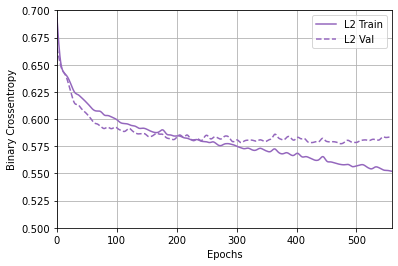

In [7]:
l2_model = tf.keras.Sequential([ \
                                    layers.Dense(512, \
                                                    activation='elu', \
                                                    kernel_regularizer = regularizers.l2(0.001), \
                                                    input_shape = (FEATURES,) \
                                                ), \
                                    layers.Dense(512, \
                                                    activation='elu', \
                                                    kernel_regularizer=regularizers.l2(0.001) \
                                                ), \
                                    layers.Dense(512, \
                                                    activation='elu', \
                                                    kernel_regularizer=regularizers.l2(0.001) \
                                                ), \
                                    layers.Dense(512, \
                                                    activation='elu', \
                                                    kernel_regularizer=regularizers.l2(0.001) \
                                                ), \
                                    layers.Dense(1)
                                ])

regularizer_histories = {}
regularizer_histories['l2']  = compile_and_fit(l2_model, 'regularizers/l2')

plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])
plt.show()
plt.close()